<a href="https://colab.research.google.com/github/WarwickAI/wai203-fin-nlp/blob/main/WAI203_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center">
    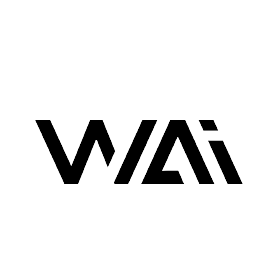
</p>

## Dependencies

In [ ]:
!pip install transformers datasets numpy sklearn wandb seaborn
!pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

## 📊 Dataset

In [ ]:
from datasets import load_dataset

# Load data here

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('dark')

plt.figure(figsize=(10, 10))
sns.countplot(data=dataset.to_dict(), x='label', palette='pastel')

plt.xticks(range(3), dataset.features['label'].names)
plt.show()

## ⚙️ Dataset processing

In [ ]:
from transformers import PerceiverTokenizer, DataCollatorWithPadding

# Initialize tokenizer
# Initialize data collator

labels = dataset.features['label'].names
id2label = { id: label for id, label in enumerate(labels) }
label2id = { label: id for id, label in enumerate(labels) }

# Tokenize the sentences

# Create training/test split

## 📏 Metrics

In [ ]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
    recall_metric = load_metric('recall')
    accuracy_metric = load_metric('accuracy')
    precision_metric = load_metric('precision')

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    recall = recall_metric.compute(
            predictions=predictions,
            references=labels,
            average='macro'
    )['recall']

    accuracy = accuracy_metric.compute(
            predictions=predictions,
            references=labels
    )['accuracy']

    precision = precision_metric.compute(
            predictions=predictions,
            references=labels,
            average='macro'
    )['precision']

    return {
        'recall': recall,
        'accuracy': accuracy,
        'precision': precision
    }

## 🚂 Training

In [ ]:
import wandb
from huggingface_hub import notebook_login

#@title Training Settings

#@markdown ---
#@markdown #### Upload Model?
#@markdown By ticking this box, your model will be automatically uploaded to the HuggingFace Hub. You will need to create an account.
#@markdown (Recommended)
upload_model_tokenizer = False #@param {type:"boolean"}

#@markdown ---
#@markdown #### Use Weights & Biases?
#@markdown By ticking this box, you will be able to visualize your experiments live [here](https://wandb.ai).
#@markdown (Recommended)
use_wb = True #@param {type:"boolean"}

#@markdown ---
#@markdown #### Model name
#@markdown The name of your model. This will be used as the public model name if you decide to upload it.
model_name = 'my_model' #@param {type:"string"}

if upload_model_tokenizer:
    notebook_login()

if use_wb:
    wandb.login()

In [ ]:
from transformers import Trainer, TrainingArguments, \
    PerceiverForSequenceClassification

# Load the pre-trained model

# Initialize the training arguments

# Initialize the trainer

trainer.train()

if upload_model_tokenizer:
    model.push_to_hub(model_name)
    tokenizer.push_to_hub(model_name)

if use_wb:
    wandb.finish()

## ‍🔬 Model Analysis


In [ ]:
predictions = trainer.predict(tokenized_splits['test'])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(predictions.label_ids, np.argmax(predictions.predictions, axis=-1))

plt.figure(figsize=(10, 10))

sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})

conf_plot = sns.heatmap(
    matrix,
    annot=True,
    cmap='Blues',
    square=True,
    cbar=False,
    xticklabels=labels,
    yticklabels=labels,
    fmt='g'
)

conf_plot.set_yticklabels(conf_plot.get_yticklabels(), rotation = 0)

conf_plot.xaxis.set_ticks_position('top')
conf_plot.xaxis.set_label_position('top')

conf_plot.set_xlabel('Predicted sentiment', labelpad=20)
conf_plot.set_ylabel('True sentiment', labelpad=20)

plt.show()

## Inference

In [ ]:
#@markdown ---
#@markdown #### Sentence
#@markdown ###### Run cell to predict the sentiment
text = 'WarwickAI stock price sky rockets after IPO.' #@param {type:"string"}
#@markdown ---

inference_prediction = trainer.predict([tokenizer(text, truncation=True)])

predicted_sentiment = id2label[np.argmax(inference_prediction.predictions)]
print(f'The sentence is {predicted_sentiment}.')